In [68]:
import os
import lasio 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [69]:
def collect_las_data_2(data_folder:str, search_string):
    '''
    Reads every .las file in data_folder

    Returns:
    - well_names : list of wells included in data_folder
    - curve_dict : curve names and associated wells+units that include this curve
    '''

    well_names = []
    curve_dict = {}

    # Iterate through each file in the folder
    for filename in os.listdir(data_folder):
        if (search_string in filename) and (filename.endswith('.las')):
            file_path = os.path.join(data_folder, filename)
            las = lasio.read(file_path)

            # Get well name
            well_name = las.well.WELL.value
            well_names.append(well_name)

            # Get curve names and associate with the well
            for curve in las.curves:
                curve_name = curve.mnemonic
                curve_unit = curve.unit

                if curve_name not in curve_dict:
                    curve_dict[curve_name] = {"wells": [], "unit": []}

                curve_dict[curve_name]["wells"].append(well_name)
                curve_dict[curve_name]["unit"].append(curve_unit)


    # Remove duplicates from well names
    well_names = list(set(well_names))

    return well_names, curve_dict


In [70]:
def extract_target_data_2(data_folder, target_curves, search_string, nr_common_items=4):
    '''
    Reads every .las file in data_folder

    Returns:
    - well_names : list of wells included in data_folder
    - dataframe : Contains a dataframe of all the wells that fit the "search_string" condition. 
                  The columns in the dataframe contain only the variables that are defined 
                  in the "target_curves" variable

    The funcion also creates a new variable "CALI_corr" (if both CALI and BS are available for a given well),
    where CALI_corr = CALI - BS
    '''
    
    well_names = []
    
    # Iterate through each file in the folder
    for filename in os.listdir(data_folder):
        if (search_string in filename) and (filename.endswith('.las')):

            # Construct full file path
            file_path = os.path.join(data_folder, filename)
            las = lasio.read(file_path)

            # Get well name
            well_name = las.well.WELL.value
            
            # ---------------------------------------------
            # Check available curves for current well data
            available_curves = [curve.mnemonic for curve in las.curves]
            # ---------------------------------------------

            # ---------------------------------------------  
            # Convert lists to sets to find common items
            common_items = set(available_curves) & set(target_curves)
            
            
            # Check if there are at least two common items and define that 'DEPT' MUST be available
            if (len(common_items) >= nr_common_items) and ('DEPT' in available_curves):  

                print(f'{well_name}: {common_items}') 
                
                # Extract DEPTH and the available curves
                data = {curve: las[curve] for curve in common_items}
                data['DEPT'] = las['DEPT']  # Assuming DEPTH is stored as 'DEPTH'
                data['well_name'] = well_name

                well_names.append(well_name)

                # Convert to DataFrame
                df = pd.DataFrame(data)

                # --------------------------------------------
                #  if CALI and BS in common item then correct CALI for BS
                # --------------------------------------------
                if all(element in common_items for element in ['CALI', 'BS']):
                    df['CALI_corr'] = df['CALI'] - df['BS']


            # Combine all DataFrames into one
            if 'combined_df' in locals():
                combined_df = pd.concat([combined_df, df], join='outer', ignore_index=True)
            else:
                combined_df = df

        #print(len(combined_df))
 
        
    # Remove duplicates from well names
    well_names = list(set(well_names))

    return combined_df, well_names




## Look at well data

In [71]:
# --------------------------------------------
# Path to CoP data

# ********************************************
global_data_path = "../../data/"
# ********************************************

# --------------------------------------------
# Directory containing Composite logs

# ********************************************
well_folder_comp_filepath = os.path.join(global_data_path,"CoP_exploration_well_logs")
# ********************************************

# --------------------------------------------
# get list of wells included in data set. set "search_string" such that the desired
# wells are importet. If search_string = '.las', all wells are importet
# --------------------------------------------
# def collect_las_data_2(data_folder:str, search_string):

# ********************************************
well_names, curve_dict = collect_las_data_2(well_folder_comp_filepath, '.las')
# ********************************************

In [72]:
print(f'Number of wells in selection: {len(well_names)}')

Number of wells in selection: 1


In [73]:
# --------------------------------------------
# Lists all the variables in the dataframe with the number of wells that contain 
# the given variable
# --------------------------------------------

print("Number of wells that contain given variable:")
for curve, details in curve_dict.items():
    print(f"{curve} : {len(details['wells'])}")

Number of wells that contain given variable:
DEPT : 1
TVD : 1
SSTVD : 1
BS : 1
CALI : 1
CORE_INTERVAL : 1
CORE_CONTINUOUS : 1
ROP : 1
DEVI : 1
MUDWEIGHT : 1
AZI : 1
PEF : 1
NPHISS : 1
RHOB : 1
GR : 1
DRHO : 1
RDEP : 1
RMIC : 1
RSHA : 1
RMED : 1
DTC : 1
CLEAN_DTC : 1
PORE : 1
SWE : 1
SWJ : 1
SXO : 1
VSH : 1
MTHA : 1
PRPA : 1
NBTA : 1
ETHA : 1
AI : 1
TVDSS : 1


In [74]:
# --------------------------------------------
# Defines a new variable "sel_var" (selected variables). The variable will be used to 
# later discard all the columns that are not specified within "sel_var". --> This is 
# to get rid of the variables that are only available for a small number of wells and
# thus are not very relevant to certain tasks 
# --------------------------------------------
# If however you want to continue with all the available variables, un-comment and use the for-loop
# below. 
# --------------------------------------------

'''
sel_var = []
i=0
for curve in curve_dict.items():
    current_item = curve[0]
    sel_var.append(current_item)
    i+=1

print(sel_var)
'''

# --------------------------------------------
# Edit statement below for a user defined selection of variables. 
# OBS! Comment the line below in case you want to use the for-loop above
# --------------------------------------------

# ********************************************
sel_var = ['DEPT','TVD','TVDSS','TEMP','DTC','BS','CALI','NPHI','RHOB','GR','RDEP','RSHA','RMED','MUDWEIGHT']
# ********************************************


In [75]:
# --------------------------------------------
# Gives the same nr of wells per variable as earlier but now only for the selected variables
# --------------------------------------------
print("Number of wells that contain selected variable:")

for curve, details in curve_dict.items():
    if curve in sel_var:
        print(f"{curve} : {len(details['wells'])}")

Number of wells that contain selected variable:
DEPT : 1
TVD : 1
BS : 1
CALI : 1
MUDWEIGHT : 1
RHOB : 1
GR : 1
RDEP : 1
RSHA : 1
RMED : 1
DTC : 1
TVDSS : 1


In [76]:
# --------------------------------------------
# Sometimes i would like to continue with only a subset of the earlier selected variables. You can do this
# here by defining a new variable "target_curves". If you want target_curves to be the same as sel_var, 
# just uncomment the line at the bottom of this cell (target_curves = sel_var)
# --------------------------------------------

# ********************************************
target_curves = ['SSTVD','DEPT', 'DRHO', 'DTC', 'DTS', 'GR', 'NPHI', 'RHOB', 'RDEP', 'RSHA','CALI', 'BS'] 
# ********************************************

#target_curves = sel_var


In [77]:
# --------------------------------------------
# CREATES DATAFRAME FOR ALL THE SELECTED WELLS AND THE SELECTED VARIABLES 
# --------------------------------------------
# def extract_target_data_2(data_folder, target_curves, search_string, nr_common_items=4):
# --------------------------------------------
# The function "extract_target_data_2" takes 4 statements:
# ------
# - data_folder = directory containing well data (.las files)
# ------
# - target_curves = list variable containing a list of variable names (use f.eks the created variables "target_curves" 
#                   or "sel_var" for this)
# ------
# - search_string = a string that will be used to filter the well fiel names. All well files that contain parts or all
#                   of the defined "search_string" will be considered. E.g., if search_string = '24', all well files 
#                   that contain the nr 24 will be selected. If search_string = '.las', all wells are selected
# ------
# - nr_common_items = This sets the minimum nr of variables from the target curves a well must have to be considered.
#                     The default nr of common variables between target curves and well's available curve is set to 4.
#                     E.g. if your target variables are ['DEPT', 'DRHO', 'DTC', 'GR', 'NPHI', 'RHOB', 'RDEP', 'BS'] 
#                     and a well in the selection only has ['DEPT', 'DRHO', 'DTC'], this well will then be discarded.
#                     Set nr_common_items to your liking
# --------------------------------------------

# ********************************************
target_result_df, target_wells = extract_target_data_2(well_folder_comp_filepath, target_curves, '.las', 4)
# ********************************************

2/5-7: {'RSHA', 'BS', 'SSTVD', 'RHOB', 'CALI', 'DRHO', 'GR', 'DTC', 'RDEP', 'DEPT'}


In [78]:
# --------------------------------------------
# Return number of wells and names of all wells stored in the dataframe
# --------------------------------------------

unique_wellnames = target_result_df['well_name'].unique()
print(f'Number of wells in selection: {len(unique_wellnames)}') 

# Print well names
print(unique_wellnames)


Number of wells in selection: 1
['2/5-7']


## Check which wells have the least amount of missing data

In [79]:
cols = [col for col in target_result_df.columns if col != 'well_name']

# Calculate the percentage of non-NaN values in each column as seen over all wells in selection
data_percentage = 100-(target_result_df[cols].isna().mean() * 100)

print(data_percentage)
print(f'Number of wells: {len(target_result_df['well_name'].unique())}')


RSHA          96.228123
BS            96.291826
SSTVD        100.000000
RHOB          96.254945
CALI          96.254945
DRHO          96.254945
GR            97.693288
DTC           95.634681
RDEP          96.228123
DEPT         100.000000
CALI_corr     96.254945
dtype: float64
Number of wells: 1


In [80]:
not_nan_dataper_list=[]

for well in unique_wellnames:
    data_percentage = 100-(target_result_df[target_result_df['well_name']==well][cols].isna().mean() * 100)
    not_nan_dataper = sum(data_percentage)/len(data_percentage)
    not_nan_dataper_list.append(not_nan_dataper)
    
max_value_index = not_nan_dataper_list.index(max(not_nan_dataper_list))

print(f'Well with the least amount of empty data: {unique_wellnames[max_value_index]}')

Well with the least amount of empty data: 2/5-7


## Some visual inspection

In [81]:
# --------------------------------------------
# Select a well name
# --------------------------------------------
#wellname = '2/4-17 T3'

wellname = unique_wellnames[max_value_index]

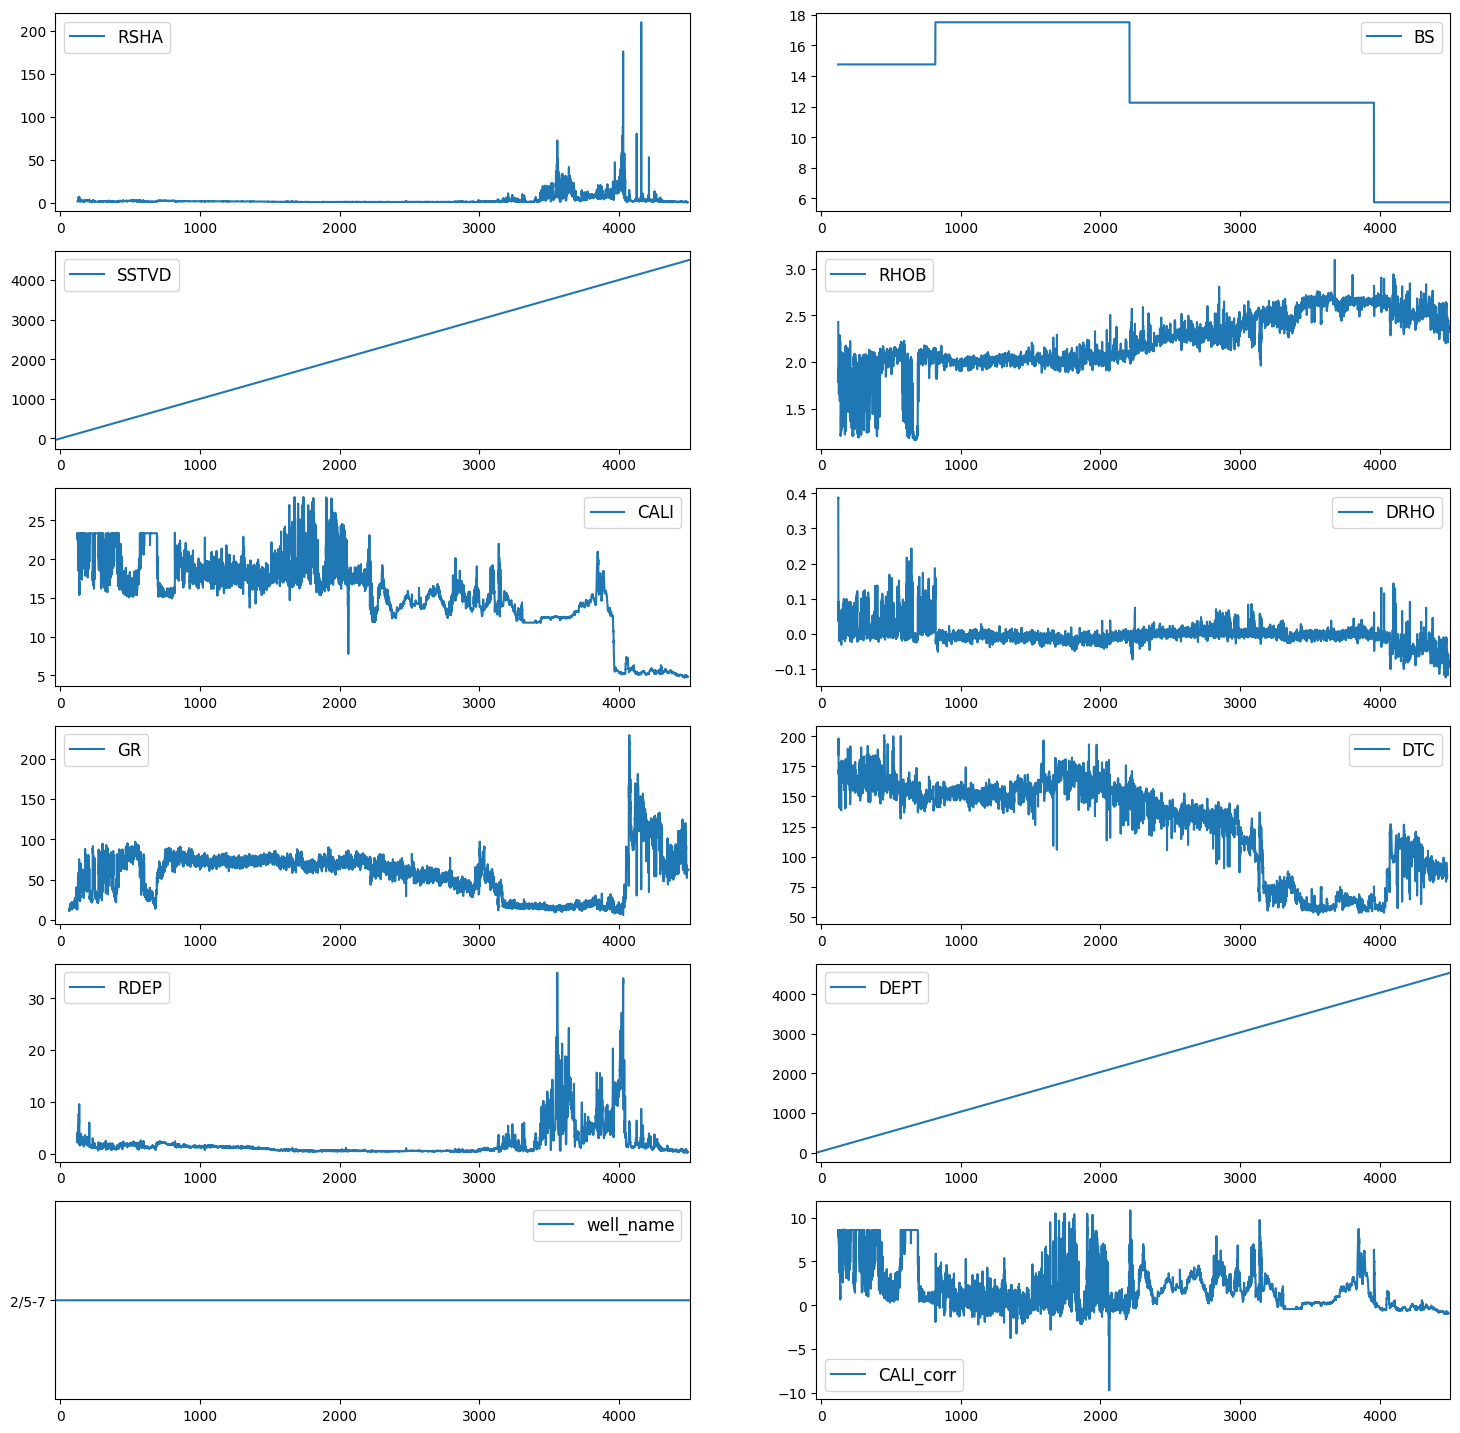

In [91]:
cols = target_result_df.columns

# counter for subplots
l1=int(np.ceil(len(cols)/2)) # always rounds to the next higher

# figure specs
fig, ax = plt.subplots(nrows=l1, ncols=2, figsize=(18, 18))
ax = ax.flatten()

m1=target_result_df['SSTVD'][target_result_df['well_name'] == wellname].min()
m2=target_result_df['SSTVD'][target_result_df['well_name'] == wellname].max()

for i in range(0,len(cols)):
    ax[i].plot(target_result_df['SSTVD'][target_result_df['well_name'] == wellname], target_result_df[cols[i]][target_result_df['well_name'] == wellname], label=cols[i])
    ax[i].legend(loc="best", fontsize=12)
    ax[i].set_xlim([m1, m2])


In [100]:
target_result_df.head(1)

,RSHA,BS,SSTVD,RHOB,CALI,DRHO,GR,DTC,RDEP,DEPT,well_name,CALI_corr
0,NaN,NaN,-35.000001,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2/5-7,NaN


In [101]:
temp_df = target_result_df.drop(columns=['well_name', 'SSTVD', 'DEPT'])

In [111]:
temp_df = temp_df.dropna()
x=temp_df.drop(columns=['DTC'])
y=temp_df['DTC']

In [115]:
# convert x and y into a numpy array and save as csv files
x.to_csv('x.csv', index=False)
y.to_csv('y.csv', index=False)